In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
import time
from contextlib import contextmanager

@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        print(f"Elapsed time: {end_time - start_time:.4f} seconds")
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True, checkpoint="")
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]
def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example
def process_sft_dataset(dataset_name, dataset, dataset_sample=None)->datasets.Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = datasets.Dataset.from_pandas(df)
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']:       # TODO: 'lavita/ChatDoctor-HealthCareMagic-100k'. not sure whether to discard the instruction.
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=2023)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset
processed_data = []
for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca","TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,general_data,math_data]):
# for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards", "TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,math_data]):
    tmp:datasets.Dataset = process_sft_dataset(name,dataset)
    print(tmp.column_names)
    processed_data.append(tmp)

cls
----------using 8*GPUs----------
>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====
['response', 'instruction', '__index_level_0__']


In [77]:
code_data = processed_data[2]
print(len(code_data))
print(code_data.column_names)

33955
['instruction', 'response']


In [78]:
print(code_data[0])

{'instruction': 'What type of structural analogs are penicillins and their derivatives, and what do they bind and inhibit?', 'response': 'Penicillins and their derivatives are D-ala-D-ala structural analogs which bind and inhibit transpeptidases.'}


# niid code 构造

In [2]:
k=100
from sklearn.cluster import KMeans
code_embeddings = model.encode(code_data["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = KMeans(n_clusters=k, random_state=0).fit(code_embeddings)
labels = kmeans.labels_
# 为每个簇创建一个数据集列表
local_datasets = []
sampled_idxs = []
for i in range(10):
    # 找到属于当前簇的所有数据点索引
    cluster_indices = np.concatenate([np.where(labels == i)[0]],axis=None)
    # 从当前簇中随机采样 10 个数据点
    sampled_indices = np.random.choice(cluster_indices, size=min(10, len(cluster_indices)), replace=False)
    sampled_idxs.extend(sampled_indices)
    # 创建一个新的数据集，只包含采样的数据点
    dataset = code_data.select(sampled_indices)
    # 将数据集添加到列表中
    local_datasets.append(dataset)

Inference Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f94d1283c70>>
Traceback (most recent call last):
  File "/home/tiger/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Inference Embeddings: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


In [80]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
label_vocab = {label: idx for idx, label in enumerate(unique_labels)}

In [4]:
from partitions import *

In [81]:
from numpy import random

# 定义生成NIID数据的函数
def generate_niid_data(code_embeddings, labels, client_num=10, alpha=1.0):
    # 将标签转换为从0开始的索引
    label_assignment = np.array([label_vocab[label] for label in labels])
    
    # 调用 label_skew_process 生成分区结果
    partition_result = label_skew_process(
        label_vocab=label_vocab,
        label_assignment=label_assignment,
        client_num=client_num,
        alpha=alpha,
        data_length=len(labels)
    )
    
    # 返回分区结果和原始标签
    return partition_result, labels

In [ ]:
partition_result, labels = generate_niid_data(code_embeddings, labels, alpha=0.01)

In [94]:
import pandas as pd

client_num=10
# 假设 code_data 是包含所有数据的DataFrame
client_data = {i: [] for i in range(client_num)}

for client_id, indices in enumerate(partition_result):
    # 根据分区结果中的索引提取对应的数据
    client_data[client_id] = code_data.select(indices)

In [ ]:
# # 将每个客户端的数据保存为Parquet格式
for client_id, data in client_data.items():
    data.save_to_disk(f'/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/niid_med_0.01_{client_id}.parquet')

In [85]:
import pandas as pd

# 假设 partition_result 是一个列表，其中包含每个客户端的标签索引列表
# 假设 label_vocab 是一个字典，将标签索引映射到标签名称
# 假设 client_num 是客户端的数量

# 计算每个客户端的每个标签的数量
client_label_counts = [[0 for _ in range(len(label_vocab))] for _ in range(client_num)]
for client_id, indices in enumerate(partition_result):
    client_labels = labels[np.array(indices)]
    for label in client_labels:
        client_label_counts[client_id][label] += 1

# 将计数转换为DataFrame
client_label_df = pd.DataFrame(client_label_counts, columns=label_vocab.values())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制热力图
plt.figure(figsize=(10, 8))  # 可以根据需要调整图形大小
sns.heatmap(client_label_df, fmt="d", cmap="YlGnBu")
plt.title('标签分布热力图')
plt.xlabel('客户端')
plt.ylabel('标签')
plt.show()

# public niid dir 构造

In [4]:
data_concated = concatenate_datasets(processed_data)

In [ ]:
k=100
from sklearn.cluster import KMeans, MiniBatchKMeans
concated_embeddings = model.encode(data_concated["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = MiniBatchKMeans(n_clusters=k).fit(concated_embeddings)
labels = kmeans.labels_

unique_labels, label_counts = np.unique(labels, return_counts=True)
label_vocab = {label: idx for idx, label in enumerate(unique_labels)}
from partitions import *
from numpy import random

# 定义生成NIID数据的函数
def generate_niid_data(concated_embeddings, labels, client_num=10, alpha=1.0):
    # 将标签转换为从0开始的索引
    label_assignment = np.array([label_vocab[label] for label in labels])
    
    # 调用 label_skew_process 生成分区结果
    partition_result = label_skew_process(
        label_vocab=label_vocab,
        label_assignment=label_assignment,
        client_num=client_num,
        alpha=alpha,
        data_length=len(labels)
    )
    
    # 返回分区结果和原始标签
    return partition_result, labels


In [16]:
partition_result, labels = generate_niid_data(concated_embeddings, labels, alpha=10)
import pandas as pd

client_num=10
# 假设 code_data 是包含所有数据的DataFrame
client_data = {i: [] for i in range(client_num)}

for client_id, indices in enumerate(partition_result):
    # 根据分区结果中的索引提取对应的数据
    client_data[client_id] = data_concated.select(indices).shuffle().select(range(5000))

client_num 10
[0.0034101120009427523, 1.47305054036404e-05, 0.013095419303836314, 0.004399510947220599, 0.006145075837551987, 0.006628727431638179, 0.012430091476438556, 0.00702399599330253, 0.006515793556876937, 0.008465130438625349, 0.002693227404632253, 0.03648500680058333, 0.006032141962790743, 0.005010826921471675, 0.01655954315792575, 0.010087941117259733, 0.008524052460239911, 0.008352196563864106, 0.014330326673508169, 0.017990857266312808, 0.01851379020814204, 0.014850804531103462, 0.008538782965643551, 0.025331559125793605, 0.015727269602620067, 0.0147550562459798, 0.005396275146200266, 0.0022464020740551606, 0.006240824122675649, 0.009324409920504373, 0.021170191349265195, 0.010240156339764018, 0.012361349117888235, 0.011956260219288124, 0.002612209624912231, 0.005796453876332497, 0.007124654446894073, 0.006668008779381221, 0.005793998792098557, 0.007119744278426193, 0.01071153251268051, 0.005514119189429389, 0.016908165119145238, 0.017497385335290855, 0.018555526640119023, 

In [17]:
# # 将每个客户端的数据保存为Parquet格式
for client_id, data in client_data.items():
    data.save_to_disk(f'/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/public_10_{client_id}.parquet')

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

## base 数据集可视化

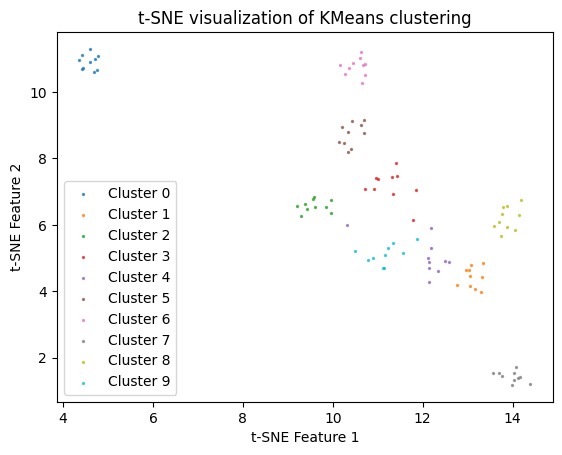

In [4]:
embeddings = []
labels = []
for i in range(10):
    embedding = model.encode(local_datasets[i]["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
# 使用 t-SNE 进行降维
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 可视化聚类结果
plt.figure()
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

## 基于 base 的密集检索

In [ ]:
import numpy as np
import random
random.seed(10)
sampled_set = set(sampled_idxs)
base_set = set(range(len(code_data)))
# 计算差集，即在 idx_set 中但不在 sampled_set 中的元素
remaining_idx = list(base_set - sampled_set)
print(len(remaining_idx))
data_concated = code_data.select(remaining_idx)
concated_embeddings = model.encode(data_concated["instruction"])
# concated_embeddings = torch.tensor(concated_embeddings, dtype=torch.float32)

client_pos_datasets = []
for i, sampled_data in enumerate(local_datasets):
    sampled_embeddings = model.encode(sampled_data["instruction"])
    client_center = np.mean(sampled_embeddings, axis=0)
    similarity_scores = client_center @ concated_embeddings.T
    top_idxs= np.argsort(-similarity_scores)[:500]
    pos_datasets = data_concated.select(top_idxs)
    pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
    pos_datasets = pos_datasets.shuffle(seed=42)
    client_pos_datasets.append(pos_datasets)

In [11]:
print(len(client_pos_datasets[0]))

510


In [ ]:
for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/niid_fewshot_{i}.parquet")

Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


<Figure size 640x480 with 0 Axes>

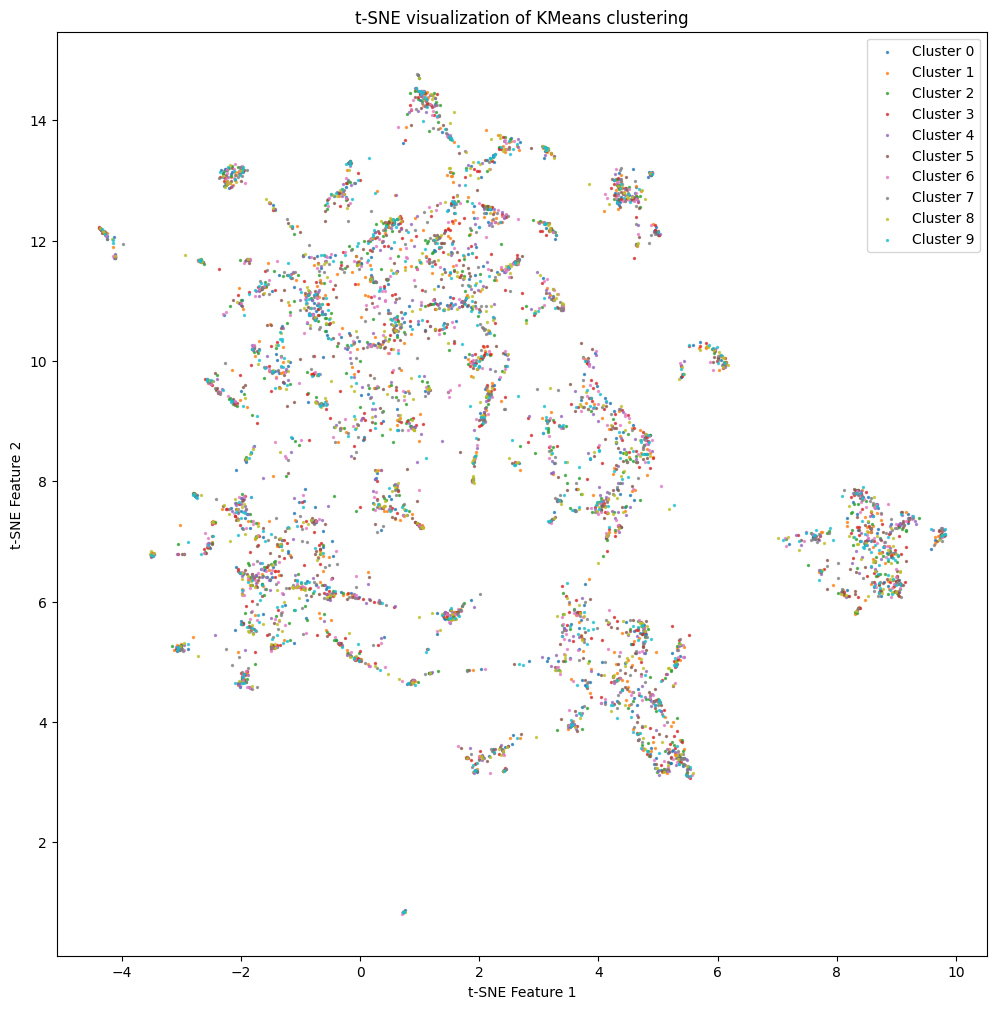

: 

In [16]:
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/iid_fewshot_{i}.parquet"))

# 遍历数据并进行 t-SNE 可视化
embeddings = []
labels = []
for i, data in enumerate(datas):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# code iid

In [14]:
client_pos_datasets = []
code_data: Dataset
for i in range(10):
    client_pos_datasets.append(code_data.shard(10,i).select(random.sample(range(int(len(code_data)/10)),510)))

In [15]:
for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/iid_fewshot_{i}.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

# public niid 构造

Inference Embeddings: 100%|██████████| 199/199 [02:06<00:00,  1.57it/s]


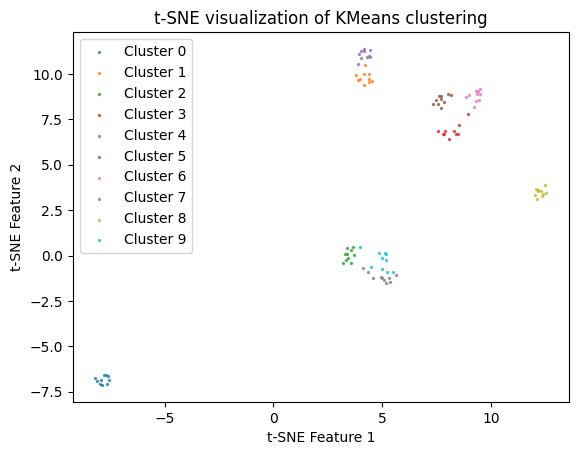

In [5]:
k=100
from sklearn.cluster import KMeans, MiniBatchKMeans
data_concated = concatenate_datasets(processed_data)
concated_embeddings = model.encode(data_concated["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(concated_embeddings)
labels = kmeans.labels_
# 为每个簇创建一个数据集列表
local_datasets = []
sampled_idxs = []
for i in range(10):
    # 找到属于当前簇的所有数据点索引
    cluster_indices = np.concatenate([np.where(labels == i)[0]],axis=None)
    # 从当前簇中随机采样 10 个数据点
    sampled_indices = np.random.choice(cluster_indices, size=min(10, len(cluster_indices)), replace=False)
    sampled_idxs.extend(sampled_indices)
    # 创建一个新的数据集，只包含采样的数据点
    dataset = data_concated.select(sampled_indices)
    # 将数据集添加到列表中
    local_datasets.append(dataset)
    
embeddings = []
labels = []
for i in range(10):
    embedding = model.encode(local_datasets[i]["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
# 使用 t-SNE 进行降维
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 可视化聚类结果
plt.figure()
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import random
random.seed(10)
sampled_set = set(sampled_idxs)
base_set = set(range(len(data_concated)))
# 计算差集，即在 idx_set 中但不在 sampled_set 中的元素
remaining_idx = list(base_set - sampled_set)
print(len(remaining_idx))

data_concated = data_concated.select(remaining_idx)
# concated_embeddings = model.encode(data_concated["instruction"])
concated_embeddings = concated_embeddings[remaining_idx]

client_pos_datasets = []
for i, sampled_data in enumerate(local_datasets):
    sampled_embeddings = model.encode(sampled_data["instruction"])
    client_center = np.mean(sampled_embeddings, axis=0)
    similarity_scores = client_center @ concated_embeddings.T
    top_idxs= np.argsort(-similarity_scores)[:500]
    pos_datasets = data_concated.select(top_idxs)
    pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
    pos_datasets = pos_datasets.shuffle(seed=42)
    client_pos_datasets.append(pos_datasets)

for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/niid_fewshot_public_{i}.parquet")

Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


<Figure size 640x480 with 0 Axes>

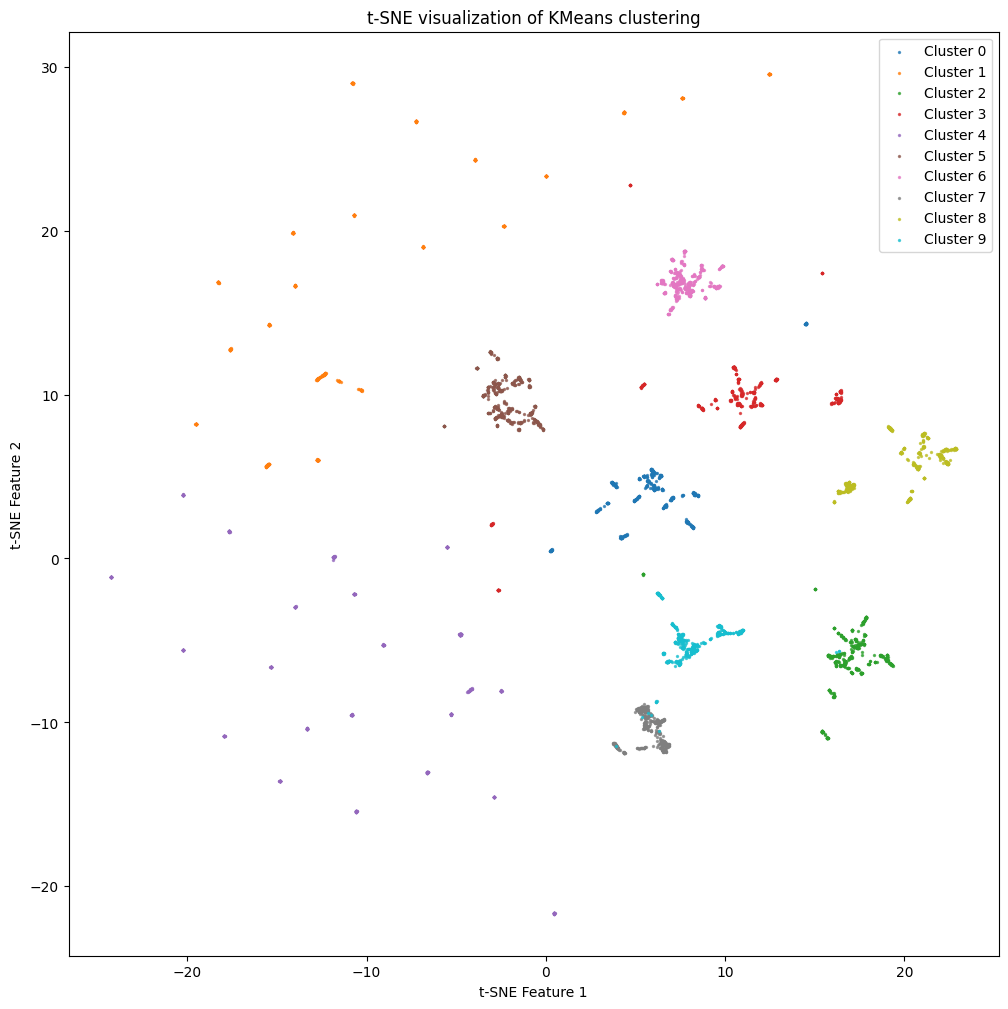

In [7]:
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/niid_fewshot_public_{i}.parquet"))

# 遍历数据并进行 t-SNE 可视化
embeddings = []
labels = []
for i, data in enumerate(datas):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()